<h1>Assessment 2 - Image Classification model for brain tumor detection (using CT scans images) </h1>


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import os


# Setting seed for random, numpy random
torch.manual_seed(24775456)
torch.mps.manual_seed(24775456)
np.random.seed(24775456)
random.seed(24775456)

## Check the amount of files after downloading, unzipping and only extract the test and train partition for classification tasks

In [40]:
import os

# base_dir == the directory that has the dataset
base_dir = os.path.join(os.getcwd(), 'dataset')
print(os.getcwd())


# Checking file number for training partition
count = 0
for label in os.listdir(os.path.join(base_dir, 'train')):
    for f in os.listdir(os.path.join(base_dir, 'train', label)):
        count += 1

print('train: ', count)



# Checking file number for testing partition
count = 0
for label in os.listdir(os.path.join(base_dir, 'test')):
    label_path = os.path.join(base_dir, 'test', label)
    if os.path.isdir(label_path):
        for f in os.listdir(label_path):
            count += 1

print('test: ', count)

/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/31005-BRISC2025 Classifier
train:  5000
test:  1000


## Declare train and test directories


In [41]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Anonymisation (this is used before but not now)

In [126]:
import os

def anonymize_filenames(folder_path, prefix):
    for i, filename in enumerate(os.listdir(folder_path)):
        ext = os.path.splitext(filename)[1]
        new_name = f"{prefix}_{i:04d}{ext}"
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))

anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/train/Healthy", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/train/Tumor", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/test/Healthy", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/test/Tumor", "img")

# Prepare dataset

In [42]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import Image

# initialising mean, std and toatl number of pixels
mean = torch.zeros(3)
std = torch.zeros(3)
n_pixels = 0

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transforms.ToTensor()(img)  

        n_pixels += img_tensor.numel() / 3
        mean += img_tensor.sum(dim=[1, 2])
        std += (img_tensor ** 2).sum(dim=[1, 2])

# mean and std
mean /= n_pixels
std = (std / n_pixels - mean ** 2).sqrt()

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Mean: [0.17052814364433289, 0.17052814364433289, 0.17052814364433289]
Std: [0.18196408450603485, 0.18196408450603485, 0.18196408450603485]


## Find the normalisation for the images based on the dataset (train partition)

In [43]:
from torchvision import datasets, transforms
import torch

# Normal transformation, this is used for testing and the validation subset
'''
    This normal transformation do the following:
        - Make sure that the image (MRI) are fitting the three channel input for MobileNetv2
        - Resize to 224x224 with the interpolation of the nearest 4 pixels
        - Transform to tensor and normalise to the ImageNet standard ()
'''
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),

    # Normalising using the mean and standard deviation of ImageNet dataset as this model is pretrained
    transforms.Normalize([0.1705, 0.1705, 0.1705], [0.1820, 0.1820, 0.1820])
])


# transformation for training only
augmentTransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.GaussianBlur(kernel_size=3),
    

    #because the model is too good i p-ut color jittering and lighting change
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.1705, 0.1705, 0.1705], [0.1820, 0.1820, 0.1820])
])


#This is the training set
full_train_set = datasets.ImageFolder(root=train_dir)
test_set = datasets.ImageFolder(root=test_dir, transform=transformation)

## Split Full train into a validation to test

In [44]:
from torch.utils.data import random_split

# Split indices for training and validation first before applying different transforms
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_ind, val_ind = random_split(range(len(full_train_set)), [train_size, val_size])

### Wrapper to transform subsets

In [45]:
from torch.utils.data import Subset, Dataset

class SubsetTrans(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    

train_set = SubsetTrans(Subset(full_train_set, train_ind), augmentTransform)
val_set = SubsetTrans(Subset(full_train_set, val_ind), transformation)
print(len(train_set), len(val_set), len(test_set))

4000 1000 1000


## Create loader for the three partitions

In [46]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

### Dataset visualisation

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


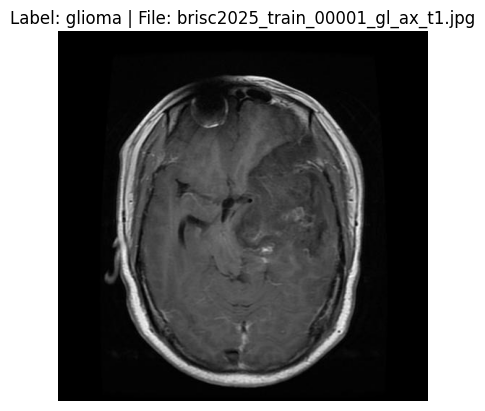

In [47]:
print(full_train_set.class_to_idx)

import matplotlib.pyplot as plt

img, label = full_train_set[0]
img_path, _ = full_train_set.samples[0]

# Extract just the filename
filename = os.path.basename(img_path)

# Display
plt.imshow(img)
plt.title(f"Label: {full_train_set.classes[label]} | File: {filename}")
plt.axis('off')
plt.show()

# Model Creation

In [48]:
import torch

print("MPS Available:", torch.backends.mps.is_available())
print("MPS Built:", torch.backends.mps.is_built())

MPS Available: True
MPS Built: True


In [49]:
import torch
print(torch.__version__)

from torch import nn
from torchvision import models as torch_model
from torchvision.models import ResNet50_Weights

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def make_model():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)
    model = torch_model.mobilenet_v2(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(model.last_channel, 4)

    #model = torch.compile(model)
    model.to(device)

    # Currently testing with default values
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer


2.8.0


# Training

In [50]:
print(device)

mps


## Training Loop

In [51]:
import numpy as np
import time
from torch.utils.data import Subset, DataLoader
import torch
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader

os.makedirs(os.path.join(base_dir, 'checkpoints'), exist_ok=True)
CP_dir = os.path.join(base_dir, 'checkpoints')

#Making the model
model, criterion, optimizer = make_model()


# Perform model training
record = []
num_epochs = 200
peak_val_acc = 0
counter = 0

for epoch in range(num_epochs):
    s = time.perf_counter()
    model.train()
    train_loss = 0
    train_acc = MulticlassAccuracy(num_classes=4).to(device)


    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        #Reset gradient first
        optimizer.zero_grad()

        train_pred = model(images)
        train_acc.update(train_pred, labels)

        # Calculate loss
        loss = criterion(train_pred, labels)

        # Back prop + Optimise
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_accuracy = train_acc.compute()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Start validating
    model.eval()

    val_loss = 0
    val_acc = MulticlassAccuracy(num_classes=4).to(device)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)
            val_pred = model(images)

            v_loss = criterion(val_pred, labels)
            val_loss += v_loss.item()
            val_acc.update(val_pred, labels)

    val_loss /= len(val_loader)
    val_accuracy = val_acc.compute()
    e = time.perf_counter()
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print(f'Time: {e-s}')
    print('-' * 50)



    # Recording results for each epoch
    record.append({"train_loss": train_loss, "train_accuracy": train_accuracy.item(), 
                   "val_loss": val_loss, "val_accuracy": val_accuracy.item()})
    



    
    # Early stopping condition
    if val_accuracy > peak_val_acc:
        print(f'best val acc so far: {val_accuracy:.4f}, saving model...')
        peak_val_acc = val_accuracy

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(CP_dir, f'best_model_epoch_{epoch}-val_acc_{val_accuracy:.4f}.pth'))

        counter = 0

    elif counter >= 10:
        print("Early stopping triggered.")
        break
    else:
        counter += 1


Using device: mps
Epoch 1/200
Training Loss: 0.9510, Training Accuracy: 0.5821
Validation Loss: 0.8911, Validation Accuracy: 0.6846
Time: 62.322917541001516
--------------------------------------------------
best val acc so far: 0.6846, saving model...
Epoch 2/200
Training Loss: 0.6918, Training Accuracy: 0.7264
Validation Loss: 0.7451, Validation Accuracy: 0.6448
Time: 62.41585333299736
--------------------------------------------------
Epoch 3/200
Training Loss: 0.5993, Training Accuracy: 0.7665
Validation Loss: 1.2193, Validation Accuracy: 0.6060
Time: 59.71607045899873
--------------------------------------------------
Epoch 4/200
Training Loss: 0.5242, Training Accuracy: 0.7905
Validation Loss: 0.6654, Validation Accuracy: 0.7042
Time: 78.15740916600043
--------------------------------------------------
best val acc so far: 0.7042, saving model...
Epoch 5/200
Training Loss: 0.4059, Training Accuracy: 0.8464
Validation Loss: 0.3563, Validation Accuracy: 0.8875
Time: 61.829169791999

# Training Visualisation

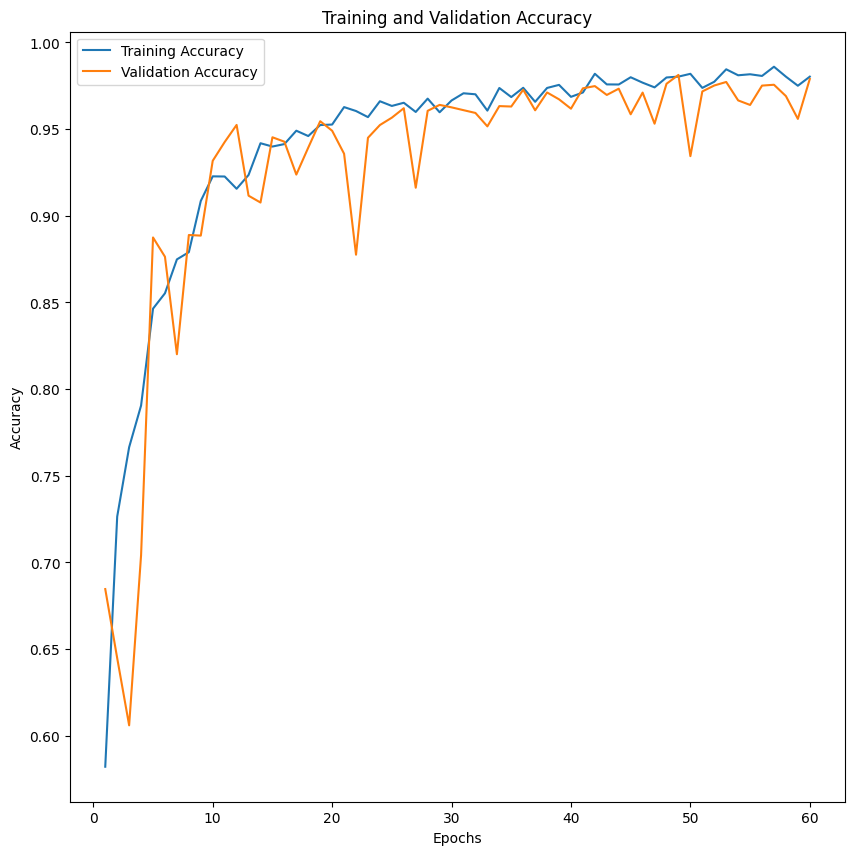

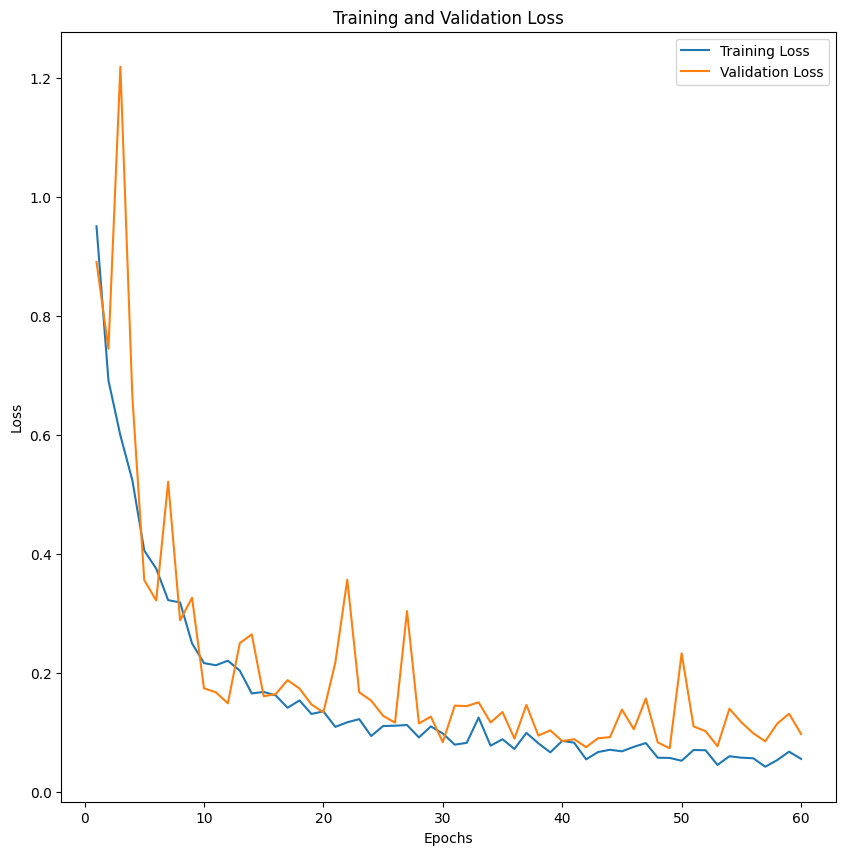

In [54]:
import matplotlib.pyplot as plt

epoch_list = list(range(1, len(record) + 1))

train_acc_list = [entry['train_accuracy'] for entry in record]
val_acc_list = [entry['val_accuracy'] for entry in record]

train_loss_list = [entry['train_loss'] for entry in record]
val_loss_list = [entry['val_loss'] for entry in record]

# Plot for accuracy
plt.figure(figsize=(10, 10))
plt.title('Training and Validation Accuracy')
plt.plot(epoch_list, train_acc_list, label='Training Accuracy')
plt.plot(epoch_list, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot for loss
plt.figure(figsize=(10, 10))
plt.title('Training and Validation Loss')
plt.plot(epoch_list, train_loss_list, label='Training Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the fully trained model

In [56]:
# Only saving the trained model for testing and further evaluation
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}, os.path.join(base_dir, 'mobilenetv2_final.pth'))

# Testing

Test Loss: 0.0906, Test Accuracy: 0.9740
--------------------------------------------------
Precision: 0.9723 | Recall: 0.9740 | F1 Score: 0.9731


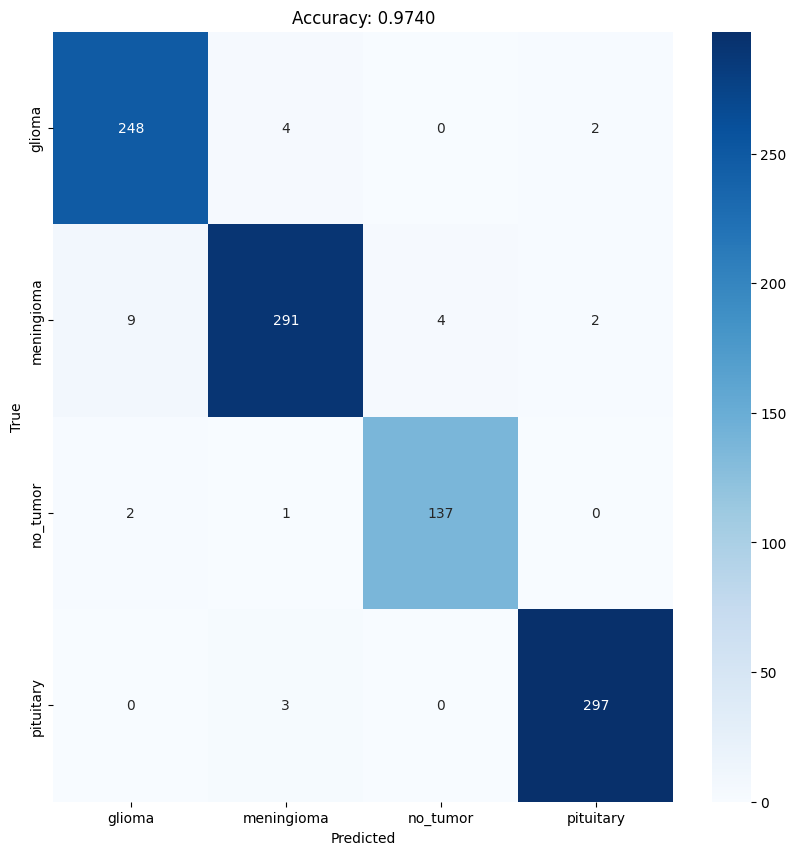

Class: glioma | Accuracy: 0.9764
Class: meningioma | Accuracy: 0.9510
Class: no_tumor | Accuracy: 0.9786
Class: pituitary | Accuracy: 0.9900
              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       254
  meningioma       0.97      0.95      0.96       306
    no_tumor       0.97      0.98      0.98       140
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluation with test data
model.eval()

test_loss = 0
test_acc = MulticlassAccuracy(num_classes=4).to(device)

# List for ground truth and predictions labels
g_truth = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)
        test_pred = model(images)

        t_loss = criterion(test_pred, labels)
        test_loss += t_loss.item()
        
        test_acc.update(test_pred, labels)

        test_pred_labels = torch.argmax(test_pred, dim=1).to('cpu')
        predictions.extend(test_pred_labels.numpy())
        g_truth.extend(labels.to('cpu').numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc.compute():.4f}')
print('-' * 50)



# Get precision, recall and f1 score for the model (with avearage only)

precision, recall, f1, _ = precision_recall_fscore_support(g_truth, predictions, average='macro')
print(f'Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}')

# Class name for confusion matrix:
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']


# Confusion matrix:
cm = confusion_matrix(g_truth, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Accuracy: {:.4f}'.format(test_acc.compute()))
plt.show()


# Detailed accuracy for each class + report classification
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(class_names):
    print(f'Class: {class_name} | Accuracy: {class_acc[i]:.4f}')

print(classification_report(g_truth, predictions, target_names=class_names))